In [1]:
%matplotlib inline
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

import util

### Data
Our data has been preprocessed in the following ways:<sup>0</sup>

1. Limited to pitcher-batter matchups of 30 or more events.
2. Limited to a select number of pitch types representing common, valid pitches.
3. Limited to events with valid zone location data.

The following columns comprise the data:


| Name | Type | Description |
|------|------|-------------|
| date_stamp | datetime | date of pitch |
| ab_total | integer | total number of events in the at-bat |
| ab_count | integer | number of the given event in the at-bat<sup>1</sup> |
| park | string<sup>2</sup> | park in which the pitch was thrown |
| des | string<sup>2</sup> | description of at-bat outcome<sup>3</sup> |
| pdes | string<sup>2</sup> | description of the pitch outcome<sup>4</sup> |
| type | string<sup>2</sup> | swing outcome<sup>5</sup> |
| sz_top | float | top of the strike zone |
| sz_bot | float | bottom of the strike zone |
| mlbam_pitch_name | str<sup>2</sup> | type of pitch<sup>6</sup> |
| zone_location | int<sup>2</sup> | strike zone sector<sup>7</sup> |
| stand | string<sup>2</sup> | side of the plate the batter stands on<sup>8</sup> |
| p_throws | string<sup>2</sup> | hand the pitcher throws with<sup>8</sup> |
| strikes | integer | number of strikes thrown in the current at-bat so far |
| balls | integer | number of balls thrown in the current at-bat so far |
| spin | float | the spin of the ball |
| inning | integer | inning number<sup>9</sup> |
| pfx_x | float | horizontal movement of the pitch<sup>10</sup> |
| pfx_z | float | vertical movement of the pitch<sup>10</sup> |
| x0 | float | initial horizontal position of the pitch<sup>11</sup> |
| y0 | float | initial depth position of the pitch<sup>12</sup> |
| z0 | float | initial vertical position of the pitch |
| vx0 | float | initial horizontal velocity of the pitch |
| vy0 | float | initial forward velocity of the pitch |
| vz0 | float | initial vertical velocity of the pitch |
| ax0 | float | initial horizontal acceleration of the pitch |
| ay0 | float | initial forward acceleration of the pitch |
| az0 | float | initial vertical acceleration of the pitch |
| start_speed | float | initial speed of the pitch |
| px | float| horizontal position of the pitch as it crosses home plate<sup>13</sup> |
| pz | float | height of the pitch as it crosses home plate |


### Goals
The primary goal is to determine the relative importance of various aspects of a pitch on batter performance.
<hr>
One of three things happens when a batter reacts to a pitch:

1. Strike - the batter swings at the ball and misses, or does not swing at a pitch thrown inside the strike zone.
2. Ball - the pitch was thrown outside the strike zone and the batter did not swing at it
3. Contact - the batter makes contact with the ball<sup>14</sup>

<hr>
In order to determine the proportional impact of pitch components, we will build models to predict each of these outcomes. We can then examine the weights assigned by our models to discern which characteristics of a pitch are most important.

### Models

We will use Random Forest Classifiers for our models. These classifiers build multiple Decision Tree classifiers from subsets of the data and then combines the results. This provides us with both flexibility and insurance against over-fitting.

Our data is divided by year; we'll train on 2010-2014 and test on 2015.

In [2]:
test = util.read_brooks(2015)

In [3]:
raw_train = pd.concat(util.read_brooks(year) for year in xrange(2010, 2015))

In [4]:
raw_X = util.pct_of(raw_train.type, 'X')
raw_S = util.pct_of(raw_train.type, 'S')
raw_B = util.pct_of(raw_train.type, 'B')
print '% X: {:%}\n% S: {:%}\n% B: {:%}'.format(raw_X, raw_S, raw_B)

% X: 18.646802%
% S: 45.348434%
% B: 36.004764%


Our classes are represented unequally in our training data. We can correct this by oversampling our `B` and `X` classes.

In [5]:
train = util.pad_training(raw_train)
pad_X = util.pct_of(train.type, 'X')
pad_S = util.pct_of(train.type, 'S')
pad_B = util.pct_of(train.type, 'B')
print '% X: {:.02%}\n% S: {:.02%}\n% B: {:.02%}'.format(pad_X, pad_S, pad_B)

% X: 33.333333%
% S: 33.333333%
% B: 33.333333%


We'll train our initial model on data we could realistically have access to *before* the pitch is thrown:    
* ab_count
* pitcher_id
* batter_id
* stand<sup>2</sup>
* strikes
* balls
* p_throws<sup>2</sup>
* x0
* y0
* z0
* park<sup>2</sup>

In [10]:
initial_cols = ['ab_count', 'pitcher_id', 'batter_id', 'factorized_stand', 'strikes', 'balls', 'factorized_p_throws', 'x0', 'y0', 'z0', 'factorized_park']

We construct a Random Forest Classifier and fit it to our data, training it to predict one of our three classes (`S`, `B`, or `X`) for each row of predictors. In order to focus on the relative information provided by our predictors, we will construct all our Random Forest models with the same parameters.

In [7]:
m_kwargs = {'n_estimators': 40, 'min_samples_split': 1, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample', 'n_jobs': -1}

We will use F1 as our evaluation metric, as it punishes under- and over-classification evenly, and handles non-binary classifications.

Initial model F1 score: 0.41303779163
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 38.089245%	Predicted S: 51.178366%	Predicted X: 10.732389%


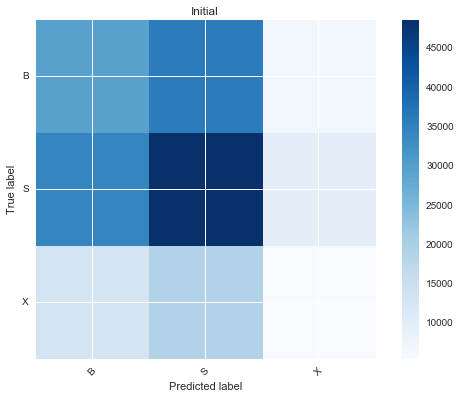

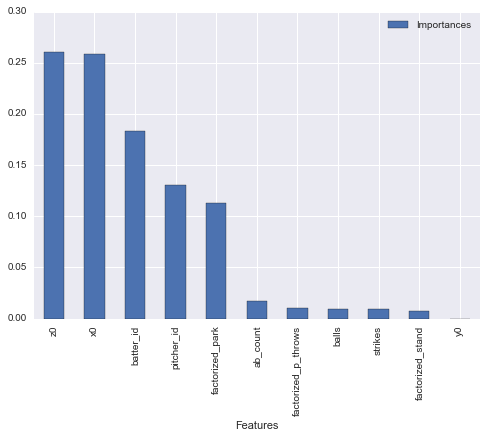

In [8]:
initial_model, initial_preds = util.train_and_plot(RandomForestClassifier, train, test, initial_cols, 'Initial', **m_kwargs)

As can be seen, `z0` and `x0` are the most informative factors. These represent the vertical and horizontal position, respectively, of the ball at the point of release.
The importance of `batter_id` and `pitcher_id` are unsurprising, although perhaps their relative ordering (and the difference between them) are. The strength of `factorized_park` is perplexing; while the dimensions and atmospheric conditions of parks are widely acknowledged to have an impact on what happens once a ball is hit, it is hard to imagine how those factors could affect *whether* a pitch is hit. Ultimately, any conclusions we could draw here must be tempered by the weak predictive power of our model.

<hr>

Our next models will incorporate more data, starting with the trajectory and speed information captured by the PITCHf/x system, up until the point the ball crosses home plate.

PFX+ model F1 score: 0.615810592712
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 36.005942%	Predicted S: 54.344532%	Predicted X: 9.649525%


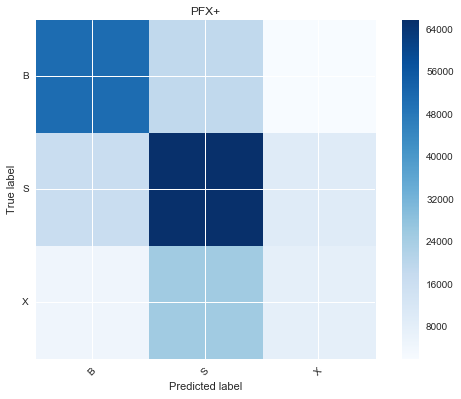

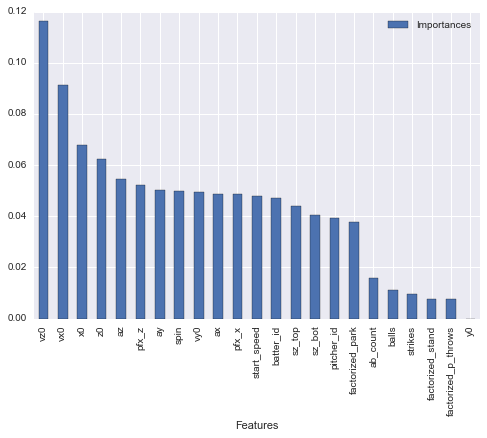

In [11]:
pfx_cols = ['sz_top', 'sz_bot', 'spin', 'pfx_x', 'pfx_z', 'start_speed', 'vx0', 'vz0', 'vy0', 'ax', 'ay', 'az']
pfx_plus_initial = initial_cols + pfx_cols
pfx_plus_model, pfx_plus_preds = util.train_and_plot(RandomForestClassifier, train, test, pfx_plus_initial, 'PFX+', **m_kwargs)

The chart above shows `vz0` and `vx0` as the most important factors, over `x0` and `z0`, suggesting initial velocity is more important than point of release. 

We can also build a model using _only_ the PITCHf/x data.

PFX model F1 score: 0.553069675388
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 37.686503%	Predicted S: 54.595752%	Predicted X: 7.717745%


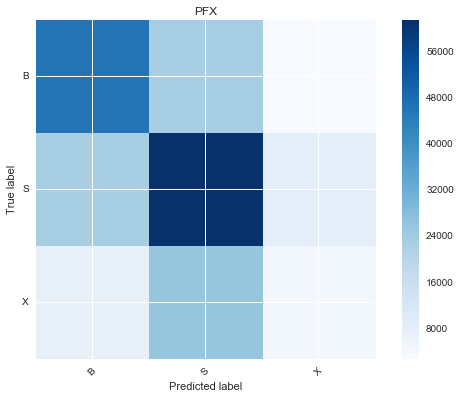

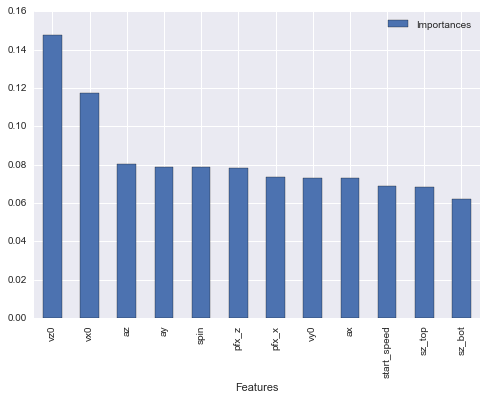

In [12]:
pfx_only, pfx_only_predictions = util.train_and_plot(RandomForestClassifier, train, test, pfx_cols, 'PFX', **m_kwargs)

The F1 scores of our models, as well as the weights they assign, clearly show that the pitch-tracking data is far more informative than the initial conditions.

The `mlbam_pitch_name` column represents the label assigned to the pitch by a neural network incorporating much of the data our `pfx` model is trained on. We can build a model incorporating this column and see how well it works in comparison to the full `pfx` model.

Pitch Name model F1 score: 0.413560961646
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 38.765911%	Predicted S: 50.663587%	Predicted X: 10.570502%


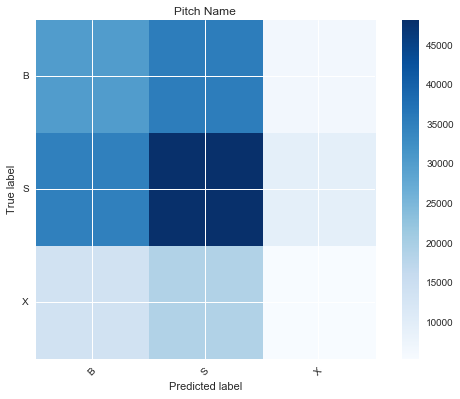

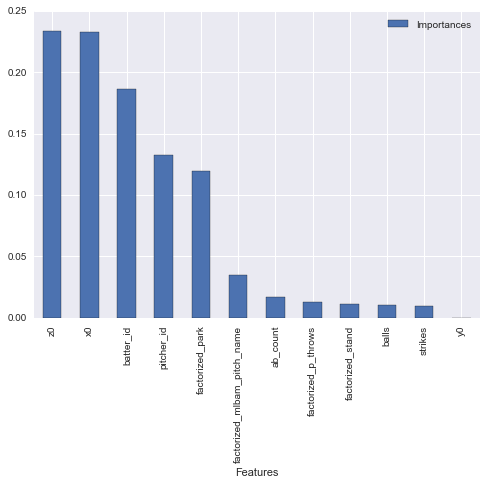

In [13]:
pn, pn_predictions = util.train_and_plot(RandomForestClassifier, train, test, preds_initial + ['factorized_mlbam_pitch_name'], 'Pitch Name', **m_kwargs)

The F1 score and plot of factor weights assigned by our most recent model clearly shows that algorithmically labeled pitch type is far less informative than the factors it comprises.

Although our models incorporate different information, certain patterns do emerge. We can see, for example, that `ab_count`, `strikes`, `balls`, `stand`, `p_throws`, and (especially) `y0` are consistently least informative across multiple models. We will build models without these columns to see if they are worse than merely useless.

No Worst model F1 score: 0.395368464693
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 37.125329%	Predicted S: 51.873294%	Predicted X: 11.001377%


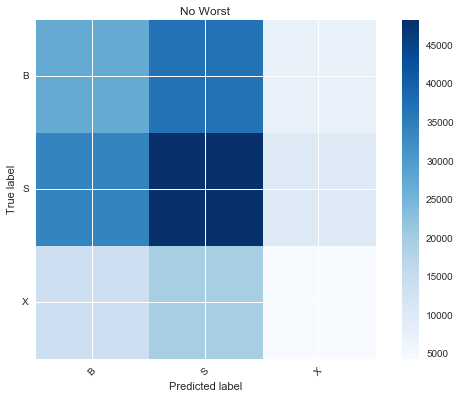

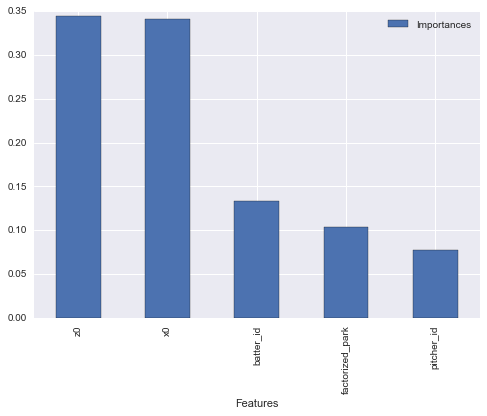

In [14]:
preds_no_worst = list(set(preds_initial).difference({'ab_count', 'strikes', 'balls', 'factorized_stand', 'factorized_p_throws', 'y0'}))
m_no_worst, no_worst_preds = util.train_and_plot(RandomForestClassifier, train, test, preds_no_worst, "No Worst", **m_kwargs)

Not terribly impressive, but perhaps that is mostly a function of having a mere 5 predictors. We can combine this limited set of predictors with our PITCHf/x data for a fairer test.

Pfx No Worst model F1 score: 0.631984443095
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 37.445647%	Predicted S: 56.326656%	Predicted X: 6.227697%


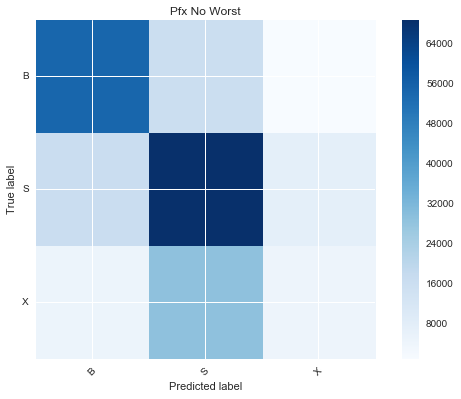

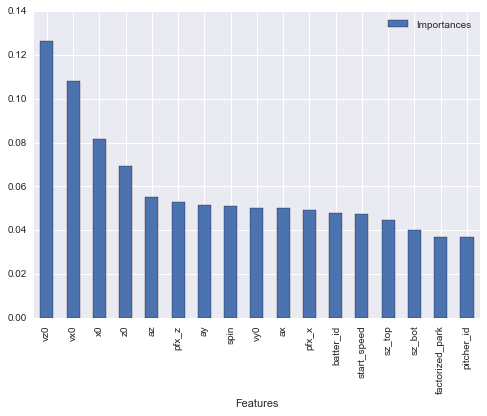

In [15]:
pfx_no_worst = preds_no_worst + pfx_cols
pnw_model, pnw_preds = util.train_and_plot(RandomForestClassifier, train, test, pfx_no_worst, 'Pfx No Worst', **m_kwargs)

As expected, dropping the least-informative columns has provided a moderate improvement to our F1 score.

Finally, we can construct a "cheater" model based on the final position of the ball as it crosses home plate.

Cheat model F1 score: 0.628144572605
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 41.815597%	Predicted S: 47.953961%	Predicted X: 10.230442%


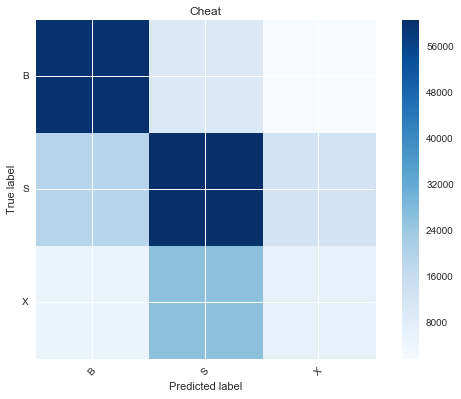

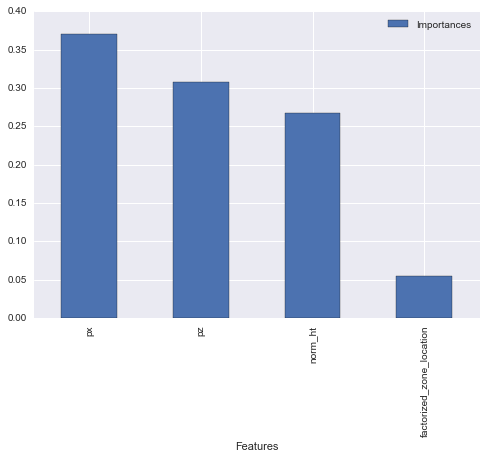

In [62]:
cheat_cols = ['px', 'pz', 'norm_ht', 'factorized_zone_location']
cheat_model, cheat_preds = util.train_and_plot(RandomForestClassifier, train, test, cheat_cols, 'Cheat', **m_kwargs)

The final ball position is surprisingly uninformative, producing a model comparable in precision and accuracy to our model trained on the combination of our most-informative initial columns and the PITCHf/x data. We can add this data to our "cheat" data to see if we can improve our F1 score.

Cheat + Initial model F1 score: 0.665220545775
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 40.733228%	Predicted S: 50.374856%	Predicted X: 8.891916%


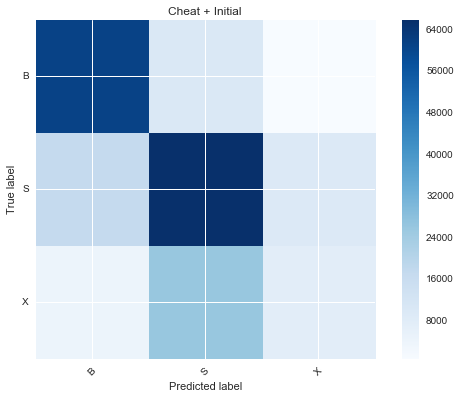

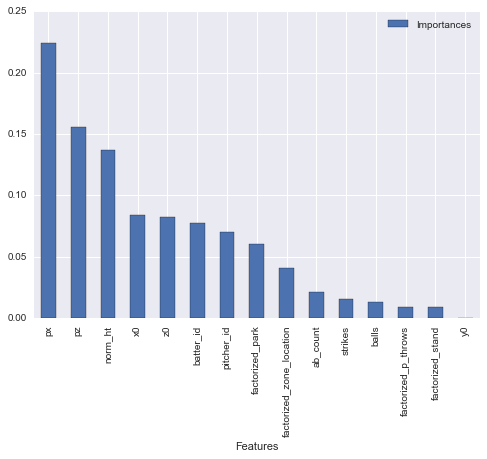

In [63]:
cheat_initial_model, cheat_initial_preds = util.train_and_plot(RandomForestClassifier, train, test, cheat_cols + initial_cols, "Cheat + Initial", **m_kwargs)

Cheat + No Worst model F1 score: 0.655956488049
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 42.571233%	Predicted S: 52.640281%	Predicted X: 4.788486%


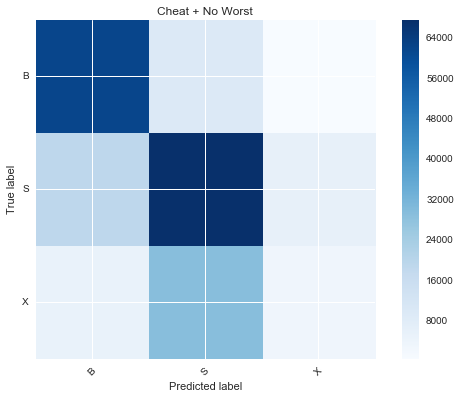

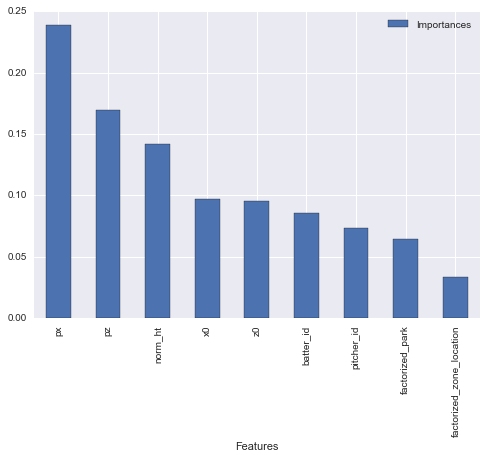

In [67]:
cheat_no_worst_model, cheat_no_worst_preds = util.train_and_plot(RandomForestClassifier, train, test, cheat_cols + preds_no_worst, "Cheat + No Worst", **m_kwargs)

All Columns model F1 score: 0.678201084837
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 39.689355%	Predicted S: 50.547601%	Predicted X: 9.763043%


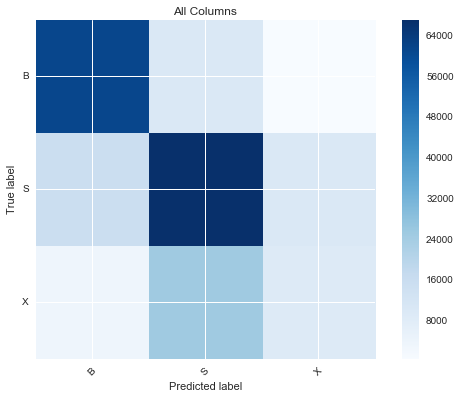

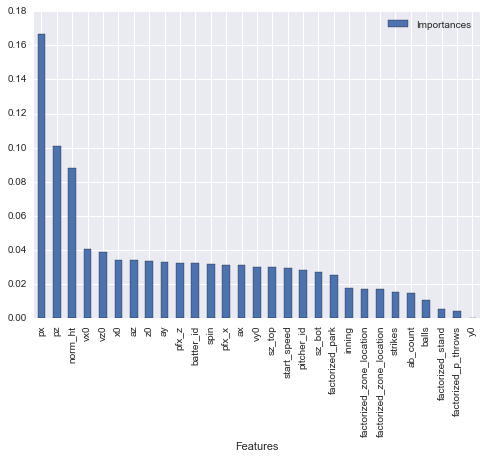

In [68]:
all_cols = pfx_cols + initial_cols + cheat_cols + ['factorized_zone_location', 'inning']
all_model, all_preds = util.train_and_plot(RandomForestClassifier, train, test, all_cols, "All Columns", **m_kwargs)

We are purposefully excluding `ab_total`, because it captures data beyond the individual pitch event&mdash;the total number of events in the at-bat. `ab_total` is wildly more predictive than our other columns, for reasons that will become clear in time.

All Columns + ab_total model F1 score: 0.843394484998
True B: 35.584445%	True S: 45.745295%	True X: 18.670260%
Predicted B: 37.931800%	Predicted S: 42.692647%	Predicted X: 19.375552%


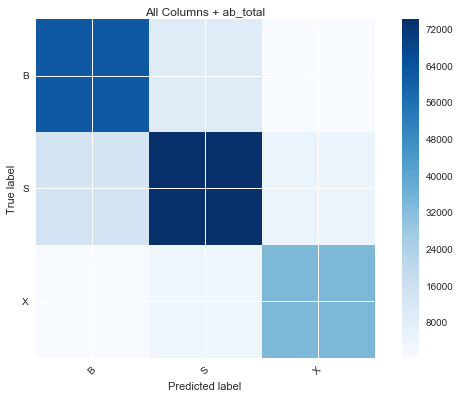

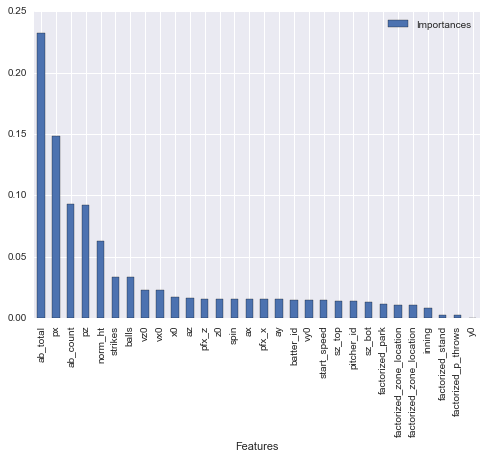

In [69]:
all_tot_cols = all_cols + ['ab_total']
atc_model, atc_preds = util.train_and_plot_and_plot(RandomForestClassifier, train, test, all_tot_cols, "All Columns + ab_total", **m_kwargs)

<hr>    
Nearly all our models radically underpredicted our `X` (hit) class, even after we balanced the ratio of classes in our training data. This merits further investigation. We'll begin by getting a sense of how hits differ from strikes and balls, using the subset of our data (PITCHf/x + our most-informative initial columns) that resulted in our best-performing model, excluding our factorized columns.

In [52]:
cols = [c for c in all_cols if not c.startswith('factorized') and not c.endswith('_id')]
train_X = train[train.type == 'X'][cols]
train_S = train[train.type == 'S'][cols]
train_B = train[train.type == 'B'][cols]

In [53]:
train_X.describe()

,x0,z0,sz_top,sz_bot,spin,pfx_x,pfx_z,start_speed,vx0,vz0,vy0,ax,ay,az
count,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000
mean,-0.710688,6.128656,3.412638,1.585737,180.289524,-0.860916,5.314137,88.678707,1.828407,-3.658213,-129.832966,-1.798019,27.049269,-22.587218
std,1.916573,0.410065,0.183793,0.110740,64.596905,6.346951,4.735198,5.491578,6.039721,2.749562,7.978913,10.803508,3.860842,8.019672
min,-4.740515,4.711733,2.792000,1.220000,0.039119,-16.884560,-11.064274,71.030000,-16.391823,-13.178879,-150.712452,-28.646001,14.634000,-47.543999
25%,-2.151083,5.867105,3.290000,1.500000,135.977000,-6.477886,2.933105,84.970000,-3.845518,-5.564038,-135.962618,-11.256000,24.163999,-27.471000
50%,-1.449682,6.139159,3.410000,1.570000,193.659000,-1.683604,6.192158,90.060000,3.844866,-3.862423,-131.838182,-2.768000,27.183001,-21.539999
75%,1.280939,6.406682,3.540000,1.660000,226.031000,4.352968,8.720278,92.900000,6.487371,-1.980952,-124.462748,6.806000,29.851999,-16.480000
max,5.056333,7.494334,4.087000,2.062000,359.998000,17.542884,18.200956,103.000000,16.003019,5.806084,-104.079209,29.282999,39.526000,0.098000


In [54]:
train_S.describe()

,x0,z0,sz_top,sz_bot,spin,pfx_x,pfx_z,start_speed,vx0,vz0,vy0,ax,ay,az
count,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000
mean,-0.704767,6.129745,3.419093,1.588830,178.222939,-0.676614,5.464792,88.661984,1.778489,-3.712865,-129.802209,-1.477839,27.175664,-22.222683
std,1.933927,0.413570,0.183677,0.111473,65.354134,6.185051,5.116303,5.654047,6.093747,2.888638,8.215705,10.509048,3.954605,8.670376
min,-4.693125,4.708884,2.790000,1.218000,-0.031081,-18.324260,-11.064784,71.010000,-17.030610,-13.244035,-152.683630,-29.921000,14.672000,-48.416000
25%,-2.166021,5.866255,3.300000,1.500000,136.910000,-6.046970,2.762490,84.840000,-3.763479,-5.753601,-136.097946,-10.504000,24.209000,-27.790000
50%,-1.449231,6.142951,3.420000,1.580000,190.693000,-1.327157,6.587525,90.100000,3.676159,-3.981042,-131.876207,-2.184000,27.320001,-20.782000
75%,1.308248,6.410347,3.540000,1.660000,222.033000,4.340963,9.249087,93.000000,6.484302,-1.956299,-124.256417,6.799000,30.061000,-15.439000
max,4.947211,7.496483,4.087000,2.062000,360.029000,17.827975,20.172005,104.230000,16.156026,5.810022,-104.016961,29.977999,39.569001,2.240000


In [47]:
train_B.describe()

,x0,batter_id,z0,factorized_park,pitcher_id,sz_top,sz_bot,spin,pfx_x,pfx_z,start_speed,vx0,vz0,vy0,ax,ay,az
count,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000,558217.000000
mean,-0.708229,429853.022704,6.132290,14.538481,441102.400230,3.420800,1.591659,178.887660,-0.755039,5.281445,88.449018,1.867015,-4.057730,-129.444535,-1.610320,27.028509,-22.593087
std,1.921688,101333.539192,0.410221,8.676201,94144.700529,0.184763,0.113314,66.671201,6.269591,5.104638,5.650265,6.505150,3.434783,8.207256,10.612815,3.917329,8.584783
min,-5.034161,110029.000000,4.709926,0.000000,110683.000000,2.790000,1.218000,-0.034768,-17.398633,-11.063224,71.010000,-17.513843,-13.299976,-153.057587,-29.484000,14.640000,-48.184001
25%,-2.159324,425834.000000,5.870063,7.000000,430935.000000,3.300000,1.500000,136.030000,-6.219463,2.662949,84.610000,-3.317691,-6.531965,-135.814055,-10.765000,24.101999,-27.954000
50%,-1.451153,451594.000000,6.145058,15.000000,453178.000000,3.420000,1.580000,191.825000,-1.439646,6.349561,89.820000,3.369212,-4.127381,-131.416207,-2.353000,27.119000,-21.279999
75%,1.289450,467798.000000,6.410745,22.000000,491646.000000,3.550000,1.660000,224.072000,4.384038,9.020208,92.830000,6.809448,-1.725091,-123.863937,6.784000,29.872999,-15.971999
max,4.862139,624585.000000,7.494195,32.000000,641490.000000,4.087000,2.062000,360.030000,16.757578,18.928831,104.990000,18.709896,5.809400,-103.967199,29.639000,39.571000,2.141000


This initial exploration confirms the difficulty of our task&mdash;the differences between our classes are slight. We can also gain some insight into the explanatory power of `ab_total`.  

In [71]:
train[train.type == 'X'].ab_total.describe()

count    558217.000000
mean          3.484437
std           1.856281
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          16.000000
Name: ab_total, dtype: float64

In [72]:
train[train.type == 'S'].ab_total.describe()

count    558217.000000
mean          5.173180
std           1.850429
min           1.000000
25%           4.000000
50%           5.000000
75%           6.000000
max          16.000000
Name: ab_total, dtype: float64

In [74]:
train[train.type == 'B'].ab_total.describe()

count    558217.000000
mean          5.163071
std           1.635035
min           1.000000
25%           4.000000
50%           5.000000
75%           6.000000
max          16.000000
Name: ab_total, dtype: float64

The summaries above reveal the significance of `ab_total`: a hit ends an at-bat, and thus at-bats containing a hit are significantly shorter than at-bats lacking a hit.

<hr>    
We can also attempt to look at individual player performance. The complicating factor in this analysis is scale: each individual player hits or pitches a small fraction of our data. We can restrict our analysis to the best-represented players in our data, but conclusions are unlikely to to prove widely generalizable.

We will start by grouping our data by player and identifying the best-represented players.

In [76]:
test_by_batters = test.groupby('batter_id')
train_by_batters = train.groupby('batter_id')
test_by_pitchers = test.groupby('pitcher_id')
train_by_pitchers = train.groupby('pitcher_id')

Since we need to test our models, we'll identify the most-frequent players in our test data, and train models on them.

In [77]:
top5_batters = test.batter_id.value_counts().index[:5]
test_top5_batters = [test_by_batters.get_group(bid) for bid in top5_batters]
train_top5_batters = [train_by_batters.get_group(bid) for bid in top5_batters]
top5_pitchers = test.pitcher_id.value_counts().index[:5]
train_top5_pitchers = [train_by_pitchers.get_group(pid) for pid in top5_pitchers]
test_top5_pitchers = [test_by_pitchers.get_group(pid) for pid in top5_pitchers]

We'll use `all_cols` (all of our columns besides `ab_total`), as it produced the best results without "cheating" too egregiously.

Batter 458015 model F1 score: 0.719733656174
True B: 41.767554%	True S: 44.067797%	True X: 14.164649%
Predicted B: 43.644068%	Predicted S: 51.755448%	Predicted X: 4.600484%


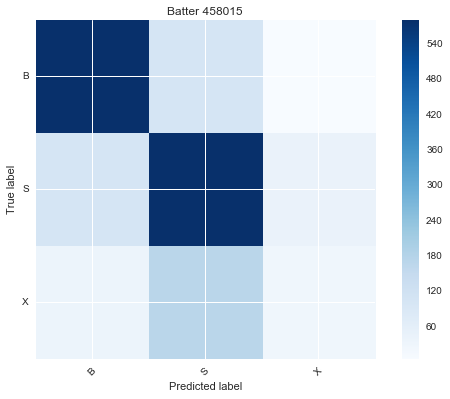

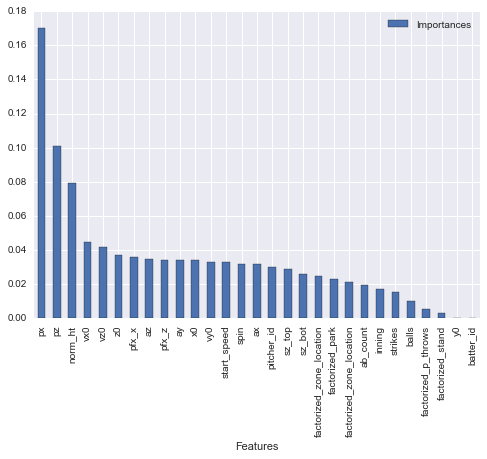

In [78]:
b1_model, b1_preds = util.train_and_plot(RandomForestClassifier, train_top5_batters[0], test_top5_batters[0], all_cols, "Batter {}".format(top5_batters[0]), **m_kwargs)

Batter 434158 model F1 score: 0.722914072229
True B: 39.103362%	True S: 45.641345%	True X: 15.255293%
Predicted B: 39.726027%	Predicted S: 54.919054%	Predicted X: 5.354919%


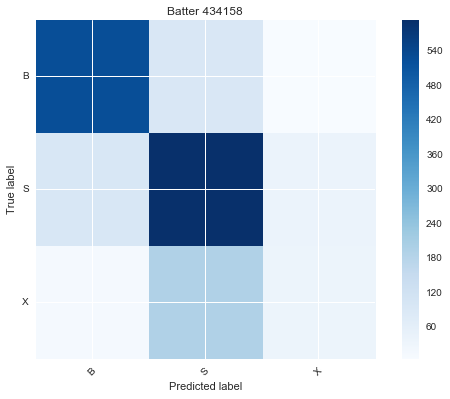

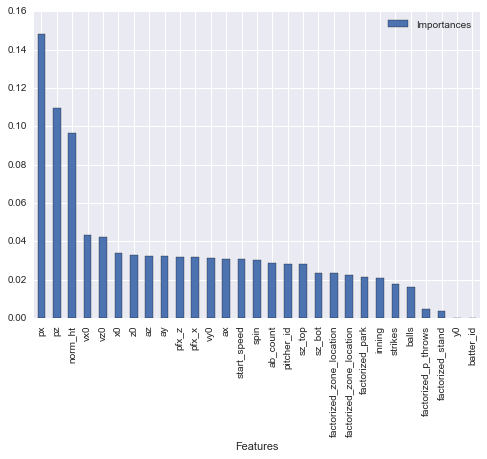

In [79]:
b2_model, b2_preds = util.train_and_plot(RandomForestClassifier, train_top5_batters[1], test_top5_batters[1], all_cols, "Batter {}".format(top5_batters[1]), **m_kwargs)

Batter 458015 model F1 score: 0.660162601626
True B: 30.650407%	True S: 49.878049%	True X: 19.471545%
Predicted B: 33.048780%	Predicted S: 60.772358%	Predicted X: 6.178862%


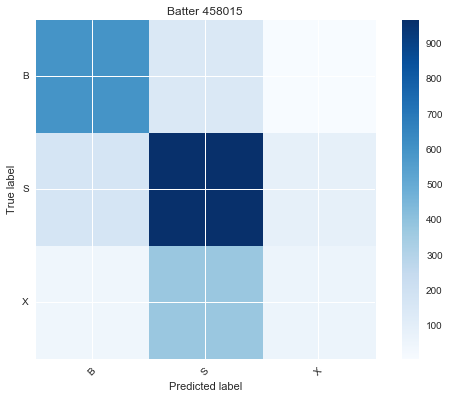

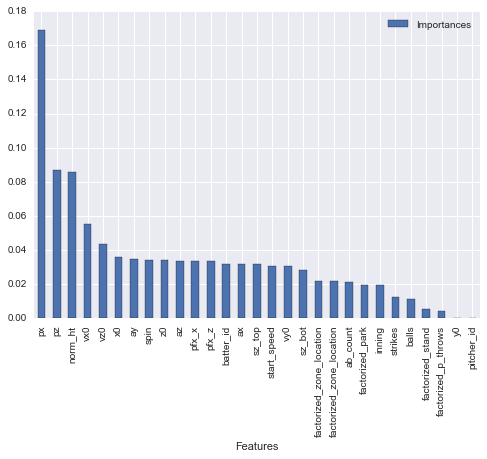

In [80]:
p1_model, p1_preds = util.train_and_plot(RandomForestClassifier, train_top5_pitchers[0], test_top5_pitchers[0], all_cols, "Batter {}".format(top5_batters[0]), **m_kwargs)

Pitcher 456034 model F1 score: 0.678861788618
True B: 30.650407%	True S: 49.878049%	True X: 19.471545%
Predicted B: 32.642276%	Predicted S: 60.406504%	Predicted X: 6.951220%


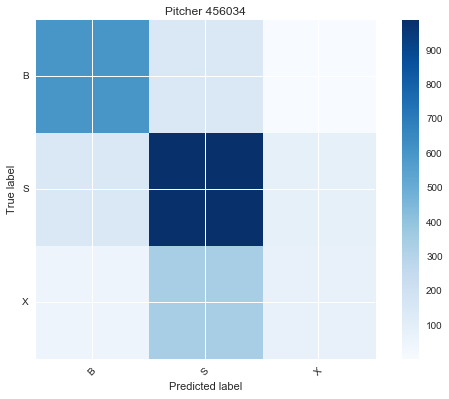

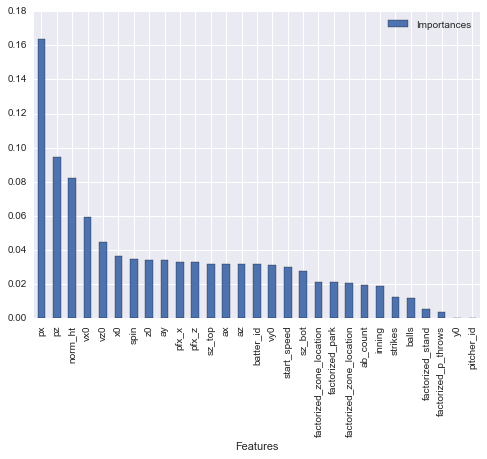

In [82]:
p1_model, p1_preds = util.train_and_plot(RandomForestClassifier, train_top5_pitchers[0], test_top5_pitchers[0], all_cols, "Pitcher {}".format(top5_pitchers[0]), **m_kwargs)

Pitcher 456034 model F1 score: 0.666260162602
True B: 30.650407%	True S: 49.878049%	True X: 19.471545%
Predicted B: 34.024390%	Predicted S: 58.373984%	Predicted X: 7.601626%


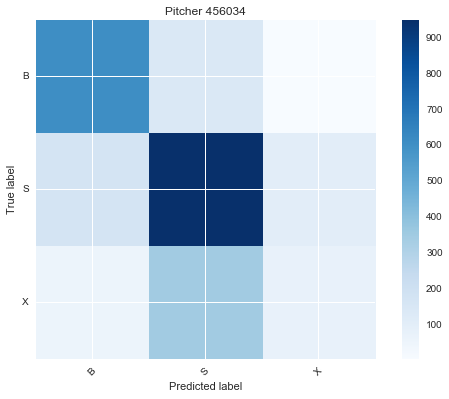

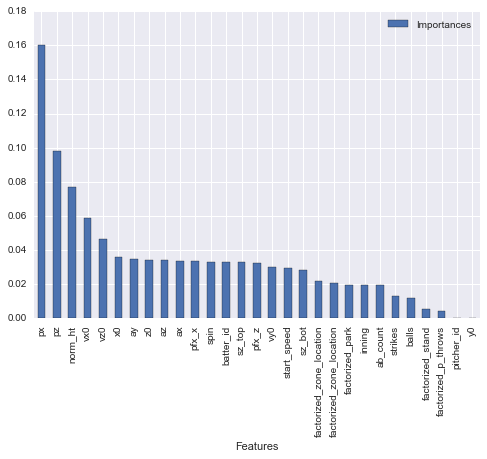

In [83]:
p1_model, p1_preds = util.train_and_plot(RandomForestClassifier, train_top5_pitchers[0], test_top5_pitchers[0], all_cols, "Pitcher {}".format(top5_pitchers[0]), **m_kwargs)

As mentioned above, the small samples involved in these calculations should temper the confidence we have in any conclusions drawn from these models. That being said, it is comforting that the weights these models assign to our factors matches those assigned by our more comprehensive efforts. It is also interesting that grouping by batter results in better models than grouping by pitcher, reinforcing the relative ordering of `batter_id` and `pitcher_id` from our first model.

<hr><br><br><br><br><br><hr>

<sup>0</sup>: Preprocessing, and other code, can be found in `util.py`.    
<sup>1</sup>: i.e. `1` for the first event, `2` for the second, etc.
<sup>2</sup>: The data in this column has been factorized.    
<sup>3</sup>: The outcome of the pitch&mdash;`Called Strike`, `In play`, `Ball`, `Foul`, etc.    
<sup>4</sup>: The outcome of the at-bat&mdash;`Groundout`, `Home Run`, `Walk`, etc.    
<sup>5</sup>: `B` for Ball, `S` for Strike, or `X` for In Play.    
<sup>6</sup>: `CH` for Changeup, `CU` for Curveball, `FC` for Fastball (Cutter), `FF` for Four-seam Fastball, `FT` for Two-seam Fastball, `SI` for Sinking Fastball, `SL` for Slider.    
<sup>7</sup>: The strike zone is a square the width of home plate, starting roughly at the batter's knees and extending to the midpoint of their torso; pitches thrown outside this square (according to the umpire) are scored as balls, provided the batter doesn't swing at them. The data divides this space into twenty-five equally-sized sections, labeled `0`-`24`, starting in the upper-left.    
<sup>8</sup>: `R` for Right or `L` for Left.    
<sup>9</sup>: 1-9    
<sup>10</sup>: i.e., deviation from a hypothetical straight line drawn from the pitcher to home plate.    
<sup>11</sup>: i.e. left-right, as seen from the axis between the batter and pitcher.    
<sup>12</sup>: i.e. distance from the batter.    
<sup>13</sup>: represented as distance from a vertical line drawn upwards from the center of home plate. Positive values are to the right of this line, negative values are to the left.    
<sup>14</sup>: Not all contact is created equal; triples are more valuable than singles. It should be noted, however, that once a ball is in play, the ultimate result is subject to numerous exogenous factors ranging from wind direction to the foot speed of the nearest fielder, and is thus less representative of a batter's 'true ability' than whether contact was made in the first place.
<sup>15</sup>: Since our data was originally a single `.csv` file, we can re-use our sorted column names.